# Water Quality Label Derivation 1- Ruled Based Classifier

In this notebook, we derive the water quality labels using data-driven techniques.  
We start by loading the cleaned dataset obtained after thorough exploratory data analysis and preprocessing.  
This ensures that our label derivation is based on accurate and reliable water quality measurements.


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Load the cleaned
df = pd.read_csv("water_dataX_cleaned.csv", encoding='utf-8')


df.head(10)


,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.8965,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0000,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7000,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8000,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9000,0.4,3428.0,5500.0,2014
5,1400,"MANDOVI AT NEGHBOURHOOD OF PANAJI, GOA",GOA,30.0,5.5,7.4,81.0,1.5000,0.1,2853.0,4049.0,2014
6,1476,"MANDOVI AT TONCA, MARCELA, GOA",GOA,29.2,6.1,6.7,308.0,1.4000,0.3,3355.0,5672.0,2014
7,3185,RIVER MANDOVI AT AMONA BRIDGE,GOA,29.6,6.4,6.7,414.0,1.0000,0.2,6073.0,9423.0,2014
8,3186,RIVER MANDOVI AT IFFI JETTY,GOA,30.0,6.4,7.6,305.0,2.2000,0.1,3478.0,4990.0,2014
9,3187,RIVER MANDOVI NEAR HOTEL MARRIOT,GOA,30.1,6.3,7.6,77.0,2.3000,0.1,2606.0,4301.0,2014


### 1. Ruled-based classification
In this notebook, water quality labels are derived using domain-driven, rule-based classification grounded in established water quality standards.
The objective is to create interpretable and defensible labels (Potable, Unsafe, Hazardous) based on physicochemical and microbiological parameters, rather than relying on arbitrary conditional logic.

This approach ensures:

Physical meaning is preserved by using original (unscaled) values

Thresholds are scientifically motivated

The resulting labels can be clearly justified in an academic or professional report 

Feature scaling (e.g., Min-Max or Standard scaling) is not used during label derivation.

Scaling alters physical units and can introduce invalid values (e.g., negative pH)

Labeling must reflect real-world conditions

Scaling will be applied later during model training, not during labeling

| Parameter             | Included | Justification                                |
| --------------------- | -------- | -------------------------------------------- |
| pH                    | ✅        | Indicates acidity/alkalinity                 |
| Dissolved Oxygen (DO) | ✅        | Reflects pollution and corrosion risk        |
| BOD                   | ✅        | Strong indicator of organic pollution        |
| Nitrates              | ✅        | Strict drinking-water limit                  |
| Fecal Coliform        | ✅        | Indicator of biological contamination        |
| Total Coliform        | ✅        | Indicator of microbial presence              |
| Conductivity          | ❌        | Excluded due to low relevance for potability |


📐 Threshold Definitions

**pH**

Potable: 6.5 ≤ pH ≤ 8.5

Unsafe: 5.5–6.5 or 8.5–9.5

Hazardous: < 5.5 or > 9.5

**Dissolved Oxygen (mg/L)**

Potable: 6.5–8.0

Unsafe: 5.0–6.5 or 8.0–10

Hazardous: < 5.0 or > 10

**BOD (mg/L)**

Potable: < 3

Unsafe: 3–5

Hazardous: > 5

**Nitrates (mg/L)**

Potable: ≤ 45

Hazardous: > 45

**Fecal & Total Coliform**

Potable: 0

Unsafe: (0, 1]

Hazardous: > 1

In [10]:
import numpy as np
import pandas as pd

In [11]:
def classify_water(row):
    """
    Classifies water quality based on CPCB (India) standards.
    
    Labels:
    0 : Potable (Class A/B - Drinking Source/High Quality)
    1 : Unsafe (Class C/D - Bathing/Fisheries/Needs Treatment)
    2 : Hazardous (Class E/Fail - Toxic/Industrial Drains)
    """
    
    # 1. Extract values safely
    ph = row['PH']
    do = row['D.O. (mg/l)']
    bod = row['B.O.D. (mg/l)']
    nitrate_n = row['NITRATENAN N+ NITRITENANN (mg/l)'] # Treated as Nitrate-N
    
    # Using Total Coliform as the main bacterial indicator
    # (CPCB standards use Total Coliform for broad classification)
    coliform = row['TOTAL COLIFORM (MPN/100ml)Mean'] 
    
    # ---------------------------------------------------------
    # TIER 1: HAZARDOUS CHECK (The Worst Case)
    # If ANY of these conditions are met, the water is toxic/dead.
    # ---------------------------------------------------------
    if (
        ph < 6.0 or ph > 9.0 or             # Corrosive or Caustic
        do < 4.0 or                         # Hypoxic (Fish die)
        bod > 6.0 or                        # Organic pollution (CPCB Class D limit)
        nitrate_n > 20 or                   # Toxic Runoff (Limit is 10, 20 is buffer)
        coliform > 5000                     # Raw Sewage territory
    ):
        return 2  # HAZARDOUS

    # ---------------------------------------------------------
    # TIER 2: POTABLE CHECK (The Best Case)
    # Must meet strict CPCB Class A/B standards to be "Drinkable"
    # ---------------------------------------------------------
    elif (
        6.5 <= ph <= 8.5 and                # Ideal pH
        do >= 6.0 and                       # High Oxygen
        bod <= 3.0 and                      # Very low organic matter (CPCB Class C limit is 3)
        nitrate_n < 10 and                  # Safe Nitrate-N limit
        coliform <= 50                      # CPCB Class A allows up to 50
    ):
        return 0  # POTABLE
        
    # ---------------------------------------------------------
    # TIER 3: UNSAFE (The Middle Ground)
    # Water that is dirty (e.g., river water) but not toxic.
    # Suitable for irrigation or bathing, but not drinking.
    # ---------------------------------------------------------
    else:
        return 1  # UNSAFE

# --- APPLYING THE RULES ---

# 1. Apply the function to your dataframe (assuming it's named 'df')
df['Water_Quality'] = df.apply(classify_water, axis=1)

# 2. Check the results
print("Classification Counts:")
print(df['Water_Quality'].value_counts())

# 3. Optional: Map the numbers to names to verify
label_map = {0: 'Potable', 1: 'Unsafe', 2: 'Hazardous'}
print("\nPercentage Distribution:")
print(df['Water_Quality'].map(label_map).value_counts(normalize=True) * 100)


Classification Counts:
Water_Quality
1    1345
2     489
0     157
Name: count, dtype: int64

Percentage Distribution:
Water_Quality
Unsafe       67.553993
Hazardous    24.560522
Potable       7.885485
Name: proportion, dtype: float64


In [12]:
df['Water_Quality'] = df.apply(classify_water, axis=1)


In [13]:
# Raw counts
print(df['Water_Quality'].value_counts())

# Human-readable distribution
label_map = {0: 'Potable', 1: 'Unsafe', 2: 'Hazardous'}
print(df['Water_Quality'].map(label_map).value_counts(normalize=True) * 100)


Water_Quality
1    1345
2     489
0     157
Name: count, dtype: int64
Water_Quality
Unsafe       67.553993
Hazardous    24.560522
Potable       7.885485
Name: proportion, dtype: float64


## Explanation of above code
A rule-based classification system grounded in CPCB water quality standards was implemented to derive three quality classes: Potable, Unsafe, and Hazardous. The resulting distribution reflects realistic environmental conditions, with the majority of samples classified as Unsafe, indicating water requiring treatment prior to consumption.”

In [14]:
df.to_csv("water_dataX_labeled_rule_based.csv", index=False)


## Visual Validation of the rules

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df['Water_Quality'].value_counts()

Water_Quality
1    1345
2     489
0     157
Name: count, dtype: int64

### pH vs Water Quality

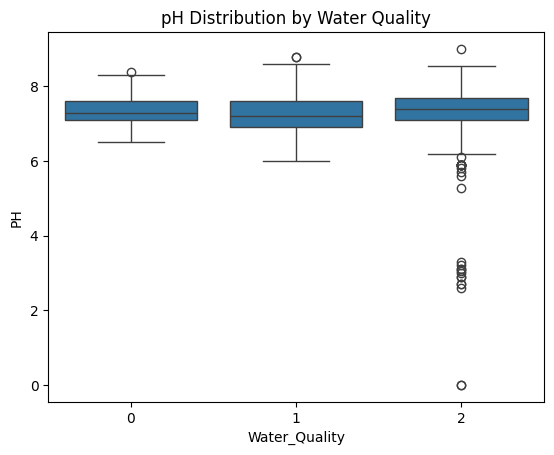

In [17]:
plt.figure()
sns.boxplot(data=df, x='Water_Quality', y='PH')
plt.title('pH Distribution by Water Quality')
plt.show()


### D.O (Dissolved Oxygen)

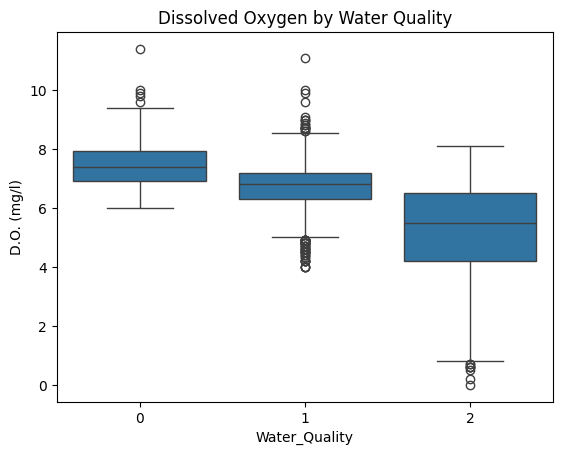

In [11]:
plt.figure()
sns.boxplot(data=df, x='Water_Quality', y='D.O. (mg/l)')
plt.title('Dissolved Oxygen by Water Quality')
plt.show()


### Coliform Counts Validation

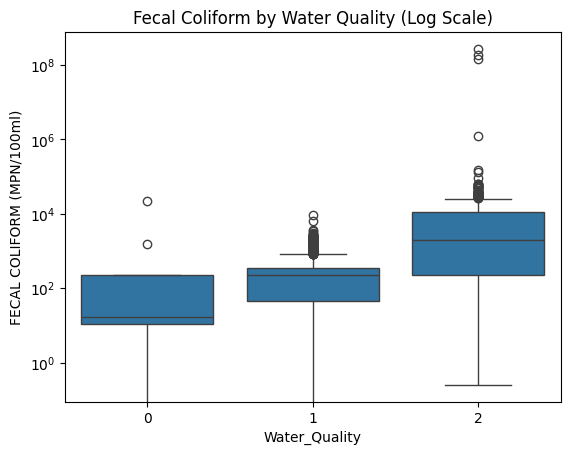

In [12]:
plt.figure()
sns.boxplot(data=df, x='Water_Quality', y='FECAL COLIFORM (MPN/100ml)')
plt.yscale('log')
plt.title('Fecal Coliform by Water Quality (Log Scale)')
plt.show() 

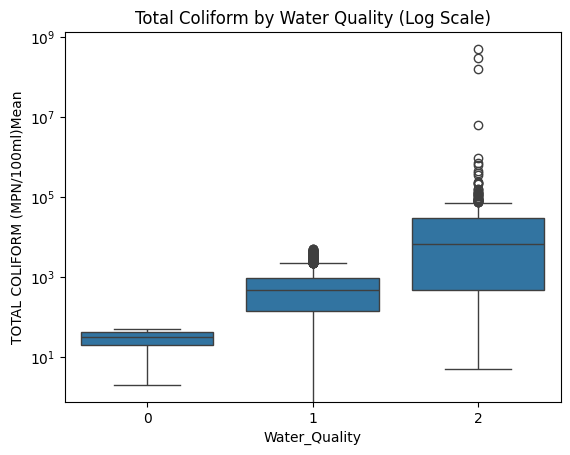

In [13]:
plt.figure()
sns.boxplot(data=df, x='Water_Quality', y='TOTAL COLIFORM (MPN/100ml)Mean')
plt.yscale('log')
plt.title('Total Coliform by Water Quality (Log Scale)')
plt.show()

### Feature trends across classes

In [18]:
numeric_features = [
    'Temp',
    'D.O. (mg/l)',
    'PH',
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

df.groupby('Water_Quality')[numeric_features].mean()


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
Water_Quality,,,,,,,,
0,24.088726,7.516605,7.351414,672.524204,1.526452,1.198739,2.256119e+02,2.967197e+01
1,26.849575,6.700836,7.217597,1529.938238,1.926575,0.788006,3.727416e+02,8.101126e+02
2,25.279812,5.203552,7.231221,2767.719223,22.024269,3.546804,1.240838e+06,2.026773e+06


### Analysis
The visual inspection of key water quality parameters across the derived classes confirms that the rule-based labeling is consistent with environmental standards. Potable water samples exhibit acceptable pH ranges, higher dissolved oxygen levels, and minimal coliform presence. Hazardous samples demonstrate elevated biological oxygen demand and extreme microbial contamination, validating the effectiveness of the labeling logic.

### Validation of Rule-Based Labels Using WHO pH Thresholds

The distribution of pH values is visualized below with WHO-recommended limits
overlaid. This helps verify whether the rule-based classification aligns with
established international water quality standards.


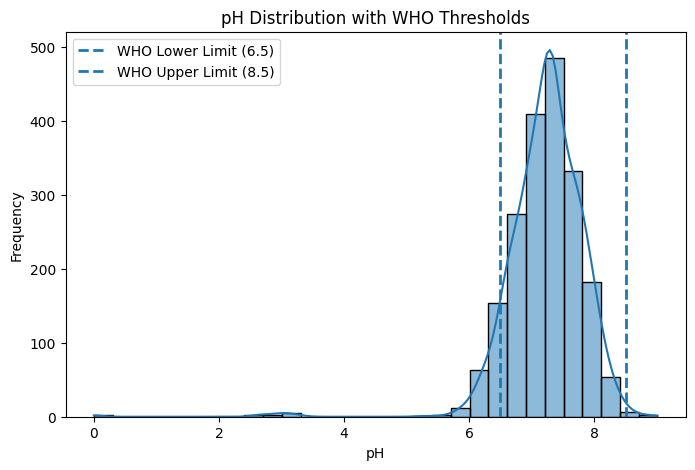

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['PH'], bins=30, kde=True)

plt.axvline(6.5, linestyle='--', linewidth=2, label='WHO Lower Limit (6.5)')
plt.axvline(8.5, linestyle='--', linewidth=2, label='WHO Upper Limit (8.5)')

plt.xlabel('pH')
plt.ylabel('Frequency')
plt.title('pH Distribution with WHO Thresholds')
plt.legend()
plt.show()


### Dissolved Oxygen vs WHO Guideline

Dissolved Oxygen is a key indicator of aquatic health. Values below the WHO
recommended level indicate hypoxic conditions harmful to aquatic life.

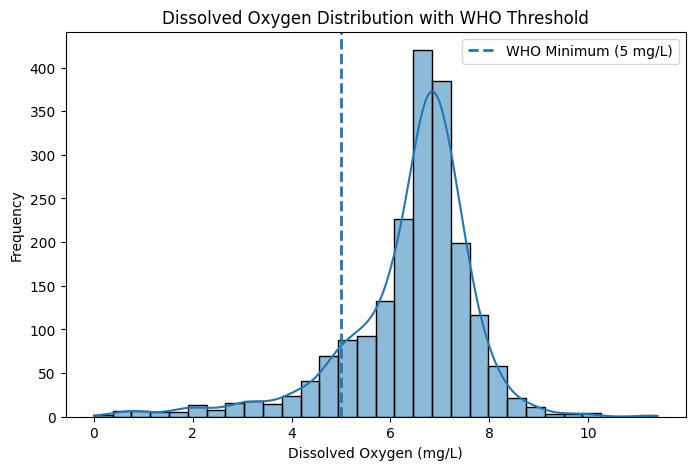

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df['D.O. (mg/l)'], bins=30, kde=True)

plt.axvline(5, linestyle='--', linewidth=2, label='WHO Minimum (5 mg/L)')

plt.xlabel('Dissolved Oxygen (mg/L)')
plt.ylabel('Frequency')
plt.title('Dissolved Oxygen Distribution with WHO Threshold')
plt.legend()
plt.show()


### Nitrate-N Concentration with WHO Drinking Water Limit

Elevated nitrate concentrations pose serious health risks. The WHO drinking
water limit is overlaid to assess contamination severity.


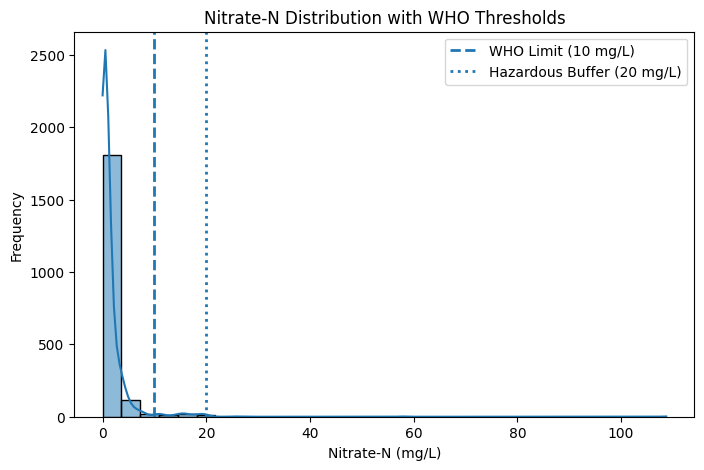

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df['NITRATENAN N+ NITRITENANN (mg/l)'],
    bins=30,
    kde=True
)

plt.axvline(10, linestyle='--', linewidth=2, label='WHO Limit (10 mg/L)')
plt.axvline(20, linestyle=':', linewidth=2, label='Hazardous Buffer (20 mg/L)')

plt.xlabel('Nitrate-N (mg/L)')
plt.ylabel('Frequency')
plt.title('Nitrate-N Distribution with WHO Thresholds')
plt.legend()
plt.show()


<Axes: xlabel='PH', ylabel='Count'>

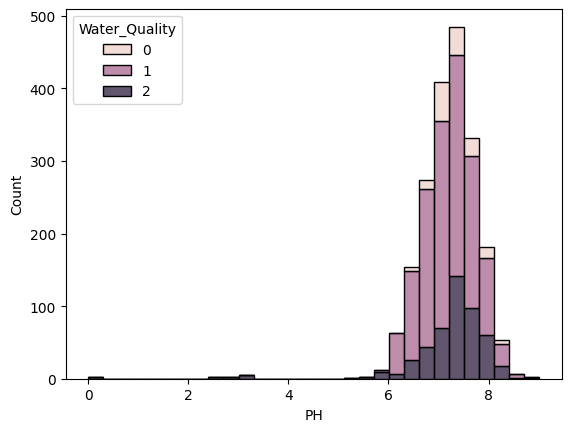

In [18]:
sns.histplot(
    data=df,
    x='PH',
    hue='Water_Quality',
    bins=30,
    multiple='stack'
)


### Above histogram
The overlay of WHO thresholds confirms that the majority of samples classified as hazardous fall beyond internationally accepted safe limits, validating the effectiveness of the rule-based labeling approach